$\def\*#1{\mathbf{#1}}$
$\DeclareMathOperator*{\argmax}{arg\,max}$

# Data Classification

In [20]:
import time

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.datasets as datasets
import sklearn.metrics as metrics
import sklearn.utils as utils

import scipy.sparse.linalg as linalg

#classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree

from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler

import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Introduction

#### Classifier

A classifier is a function $M$ that predicts the class label $\hat{y} \in \{c_1, c_2, \ldots, c_k\}$ for a given point $\*x \in \mathbb{R}^d$ :

$$\hat{y} = M(\*x)$$

#### Supervised Learning

1. Collect a **Training Data Set** composed of points along with their known classes
2. Train Classifier
3. Make Predictions

#### Collect Training Data

A training set of points with their known classes :

|Weight|Texture|Label |
|------|-------|------|
|140g  |Smooth |Apple |
|130g  |Smooth |Apple |
|150g  |Bumpy  |Orange|
|170g  |Bumpy  |Orange|

In [2]:
features = [[140, 1], [130, 1], [150, 0], [170, 0]]

labels = [0, 0, 1, 1]

#### Train Classifier

In [3]:
classifier = tree.DecisionTreeClassifier().fit(features, labels) 

#### Make Predictions

In [4]:
print(classifier.predict([[160, 0]]))

[1]


## Decision Tree

### Iris dataset

iris-setora : 50
others : 100


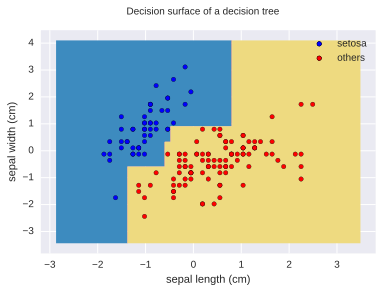

In [5]:
# http://scikit-learn.org/stable/auto_examples/tree/plot_iris.html

# Load data
iris = datasets.load_iris()

# Select the two first features, i.e., sepal length and width
features = [0, 1]
X = iris.data[:, features]
y = iris.target

# Considert two classes : iris-setora and the other two types of irises
classes = [0, 1]
class_names = [iris.target_names[0], 'others']
n_classes = 2
y[y > 1] = 1

print("iris-setora :", np.sum(y == 0))
print("others :", np.sum(y == 1))

# Shuffle
idx = np.arange(X.shape[0])
np.random.seed(13)
np.random.shuffle(idx)
X = X[idx]
y = y[idx]

# Standardize
mean = X.mean(axis=0)
std = X.std(axis=0)
X = (X - mean) / std

# Train
classifier = tree.DecisionTreeClassifier().fit(X, y)

# Plot the decision boundary
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
plot_step = 0.02
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

plt.xlabel(iris.feature_names[features[0]])
plt.ylabel(iris.feature_names[features[1]])

# Plot the training points
# Parameters
plot_colors = "bry"
for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1], c=color, label=class_names[i],
                    cmap=plt.cm.Paired)
    
plt.suptitle("Decision surface of a decision tree")
plt.legend()
plt.show()


In [6]:
from sklearn.externals.six import StringIO  

dot_file = open("iris_decision_tree.dot", 'w')  
tree.export_graphviz(classifier, out_file=dot_file,  
                     feature_names=iris.feature_names,  
                     class_names=class_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
dot_file.close()

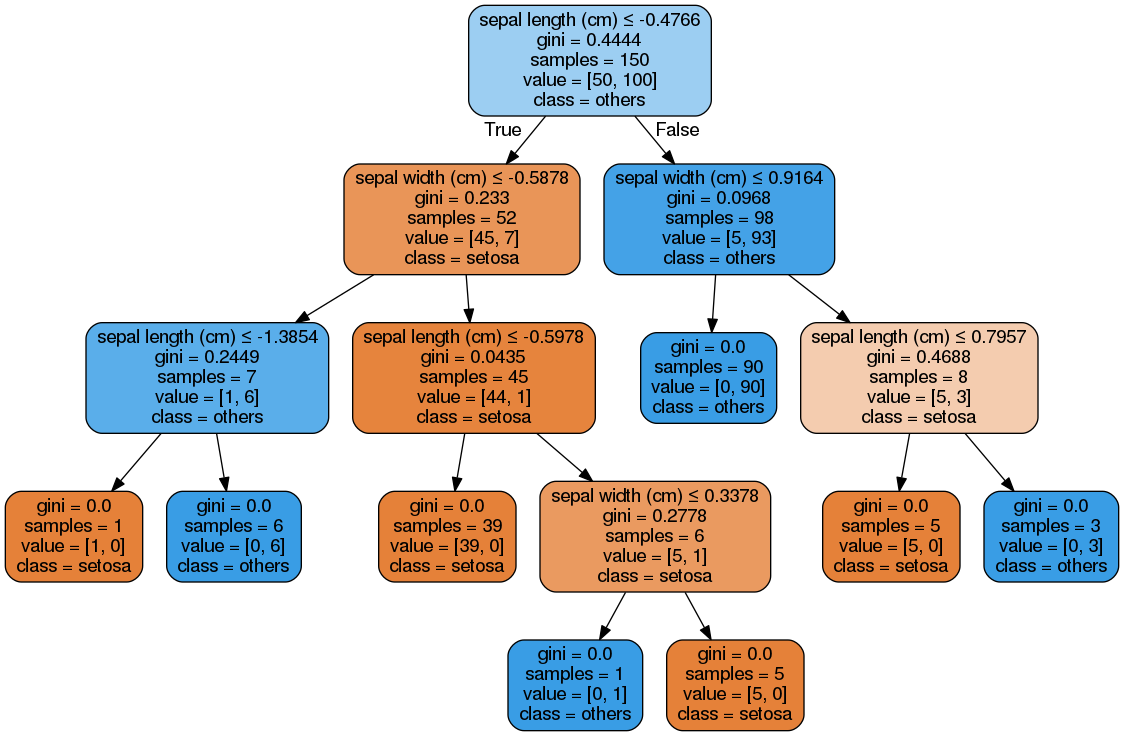

In [7]:
from IPython.display import Image
import os
os.system('dot -Tpng iris_decision_tree.dot -o iris_decision_tree.png')
Image('iris_decision_tree.png')

* Class : majority rule
* Samples : number of elements in the region
* Value : size of classes in the region

### Decision Trees

Let $\*D = \{\*x_i, y_j\}^ n_{i=1}$ denote the training set. This set consists of $n$ pairs composed of a $d$-dimensional point $\*x_i$ and its corresponding class label $y_i \in \{c_1, c_2, \ldots, c_k\}$. It is assumed that each feature is either numeric or categorial.

$$
D = 
\left(
\begin{array}{c|c}
        X & \*y\\
        \hline
  \*x_1 & y_{1}\\
  \*x_2 & y_{2}\\
  \vdots & \vdots \\
  \*x_n & y_{n}
\end{array}
\right)
=
\left(
\begin{array}{cccc|c}
        X_1 & X_2 & \cdots & X_d & \*y\\
        \hline
  x_{1,1} & x_{1,2} & \cdots & x_{1,d} & y_{1}\\
  x_{2,1} & x_{2,2} & \cdots & x_{2,d} & y_{2}\\
  \vdots  & \vdots  & \ddots & \vdots & \vdots \\
  x_{n,1} & x_{n,2} & \cdots & x_{n,d} & y_{n}
\end{array}
\right)
$$

In a **decision tree classifier**, the **data space is recursively partitioned**. This partition is represented by a **binary tree**, where each **node** corresponds to a **region** of the data space. The **root** node corresponds to the data space, each pair of **child nodes** corresponds to a partitioning of the partent node's region into two half-spaces by an *axis-parallel hyperplane*, and each external node (**leaf**) corresponds to a class label equal to the majority call among the points in the corresponding region.  

An **Axis-Parallel Hyperplane** $h(\*x)$ is defined as the set of all points $\*x$ that satisfy the the following equation,

$$
h(\*x) : x_j + b = 0,
$$

where the choice of $b$ leads to different hyperplanes along the dimension $X_j$, with $j = 1, 2, \ldots, d$.



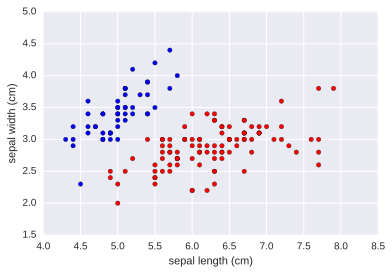

In [8]:
# Load data
iris = datasets.load_iris()

# Select the two first features, i.e., sepal length and width
features = [0, 1]
X = iris.data[:, features]
y = iris.target
# Considert two classes : iris-setora and the other two types of irises
classes = [0, 1]
class_names = [iris.target_names[0], 'others']
n_classes = 2
y[y > 1] = 1

plt.xlabel(iris.feature_names[features[0]])
plt.ylabel(iris.feature_names[features[1]])

# Plot the training points
plot_colors = "br"
for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1], c=color, label=class_names[i],
                    cmap=plt.cm.Paired)
    
#plt.axvline(x=5.55, color='g', linestyle='-')
#plt.axhline(y=2.55, color='0', linestyle='-')

#### Numerical attributes

A hyperplane defines a **decision**, or *split point*, that splits the data space $\mathcal{R}$ into two half-spaces $\mathcal{R}_Y$ and $\mathcal{R}_N$. For a **numerical attribute**, this split point is defined as follows,

$$
X_j \leqslant v,
$$

where $v = -b$ is in the domain of attribute $X_j$. The half-space $\mathcal{R}_Y$ denotes the set of all possible points that **satisfy this decision**. Conversely, the half-space $\mathcal{R}_N$, denotes all the possible points that **do not satisfy this decision**.

This split of the data space $\mathcal{R}$, induces a binary partition of the corresponding data points $\*D$ defined as follows,

* $\*D_Y = \{\*x : \*x \in \*D, x_j \leqslant v\}$
* $\*D_N = \{\*x : \*x \in \*D, x_j > v\}$

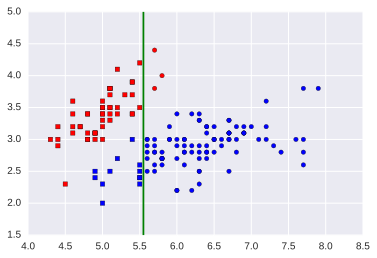

In [9]:
v = 5.55

R = np.zeros(len(y))
spaces = [0, 1]
R[X[:,0] <= v] = 1 #Dy

# Plot the training points
plot_colors = "rb"
for i, color in zip(range(n_classes), plot_colors):
    space_markers = ['o', 's']
    for j in spaces:
        idx = np.where((y == i) & (R == j))
        plt.scatter(X[idx, 0], X[idx, 1], c=color, marker=space_markers[j])

plt.axvline(x=5.55, color='g', linestyle='-')

#### Categorical attributes

For a **categorical attribute**,  the split points is defined as follows,

$$
X_j \in V,
$$

where $V \subset dom(X_j)$, a strict subset of the domain of $X_j$.

#### Region Evaluation

The **purity** of a region is defined as follows,

$$
purity(D_j) = \max_{i} \left\{\frac{n_{ji}}{n_j}\right\},
$$

where $n_j = |\*D_j|$ and $n_{ji}$ is the number of points in $D_j$ labeled with $c_i$

#### Algorithm

This algorithms takes as input three arguments, the training data set $\*D$, the leaf size $\nu$, and the leaf purity threshold $\pi$. The best split point is determined with respect to a given evaluation function, and the partioning is performed rescursively on each half-space. The partitioning process stops if either the number of data points is less than $\nu$ or the purity is greater than $\pi$.

#### Split Point Evaluation Measure

The **Gini index** is used to measure the purity of a split point. The Gini index of a given data set $\*D$ is defined as follows,

$$
G(\*D) = 1 - \sum_{i = 1}^k  P(c_i|\*D)^2
$$

where $P(c_i|\*D)$ is the probability of class $c_i$ in the data set $\*D$ and $k$ is the number of classes.

* *If the partition is pure* : the porbability of the majority class is 1 and the probability of others is 0, therefore the Gini index is 0.
* *Otherwise* : each class is equally represented (*i.e.*, $P(c_i|\*D) = \frac{1}{k}$, for all $i = 1,\ldots,k$), therefore the Gini index is equal to $\frac{k-1}{k}$.

For a given **split point**, the **weighted Gini index** is defined as follows

$$
G(\*D_Y, \*D_n) = \frac{n_Y}{n} G(\*D_Y) + \frac{n_N}{n} G(\*D_Y)
$$

where, $n_Y$ and $n_N$ denote the number of points in $\*D_Y$ and $\*D_N$ respectively.
#### Computational Complexity

$$
O(dn^2 \log n)
$$

## k-Nearest Neighbors

#### Generate data points forming to different cycles

In [10]:
X, y = datasets.make_circles(noise=.1, factor=.5)
print("X.shape:", X.shape)
print("unique labels: ", np.unique(y))

X.shape: (100, 2)
unique labels:  [0 1]


#### Plot the data

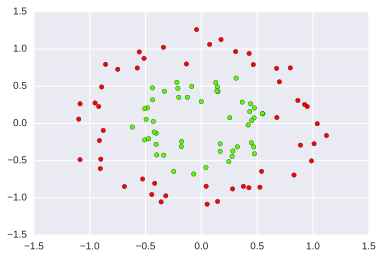

In [11]:
plt.prism()  # this sets a nice color map
plt.scatter(X[:, 0], X[:, 1], c=y)

#### Take the first 50 examples for training and the rest for testing.

In [12]:
X_train = X[:50]
y_train = y[:50]
X_test = X[50:]
y_test = y[50:]

#### Try to classify the points (in the two classes) using a k-nn classifier:

In [13]:
knn = KNeighborsClassifier(n_neighbors=5)    # we specify that this knn should always use 5 neighbors

In [14]:
knn.fit(X_train, y_train)

y_pred_train = knn.predict(X_train)
print("KNN validation accuracy on training cycles: ", knn.score(X_train, y_train))

y_pred_test = knn.predict(X_test)
print("KNN validation accuracy on test cycles: ", knn.score(X_test, y_test))

KNN validation accuracy on training cycles:  0.96
KNN validation accuracy on test cycles:  0.84


#### Plot the result

Accuracy of KNN test set: 0.84


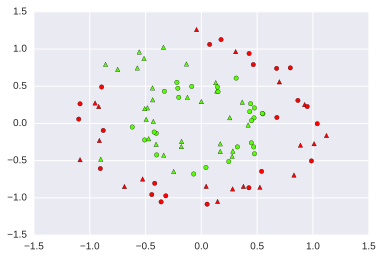

In [15]:
plt.prism() # gives us a nice color map

plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)

plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_test, marker='^')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

print("Accuracy of KNN test set:", knn.score(X_test, y_test))

## Probabilistic Classification

We consider a dataset $D = \{\*x_1, \ldots, \*x_n\}$, with $y_i \in \{c_1, c_2, \ldots, c_k\}$ for all $i = 1, 2, \ldots, n$. The **predicted class** for a new data point $\*x$ is obtained as follows :

$$
\hat{y} = \argmax_{c_i}\{P(c_i | \*x)\}
$$

**Bayes' formula**

Let $E_1, E_2, \ldots, E_k$ be a partition of $\Omega$ :

* $\Omega = E_1 \cup E_2 \cup \ldots \cup E_k$ 
* $E_i \cap E_j = \emptyset$, for all pair $i, j \in \{1, 2, \ldots, k\}$

Based on the probability axioms and elementary set theory, it can be showed that the **marginal probability** $P(E)$ is equal to :

$$
P(E) = P(E \cap \Omega) = P(E_1 \cap E) + P(E_2 \cap E) + \ldots + P(E_k \cap E)
$$

Based on conditional probability, this can be rewritten as follows :

$$
P(E) = P(E_1) P(E | E_1) + P(E_2) P(E | E_2) + \ldots + P(E_k) P(E | E_k)
$$

This leads to the **Bayes's formula** :

$$
P(E_i|E) = \frac{P(E_i \cap E)}{P(E)} = \frac{P(E_i)P(E|E_i)}{\sum_{l = 1}^k P(E_l)P(E|E_l)}
$$

### Bayes Classifier

Based on this formula, The **predicted class** for a new data point $\*x$ is obtained as follows :
$$
\begin{align}
\hat{y} &= \argmax_{c_i}\{P(c_i | \*x)\}\\
        &= \argmax_{c_i}\Bigg\{\frac{P(\*x | c_i) P(c_i)}{P(\*x)}\Bigg\}\\
        &= \argmax_{c_i}\{P(\*x | c_i) P(c_i)\}
\end{align}
$$

**Prior Probability Estimator** :

$$
\hat{P}(c_i) = \frac{|\*D_i|}{|\*D|} = \frac{n_i}{n}
$$

where $\*D_i = \{\*x_j \in \*D : y_j = c_i\}$, $|\*D| = n$, and $|\*D_i| = n_i$.

**Likelyhood estimator**, *i.e.* and estimator for $P(\*x | c_i)$ : see previous labs/lectures.

### Naive Bayes Classifier

In this case we assume that attributes are independent. This allows to write the likelyhood as follows :
    
$$
P(\*x|c_i) = P(x_1, x_2, \ldots, x_n | c_i) = \prod_{j = 1}^d P(x_i|c_i)
$$

For **numerical attributes**, we can, for example, assume a normal distribution for each clas $c_i$ :

$$
P(x_j | c_i) \propto f(x_j) = \frac{1}{\sqrt{2\sigma_{ij}^2\pi} } \; e^{ -\frac{(x_-\mu_{ij})^2}{2\sigma_{ij}^2} }
$$

where $\mu_{ij}$ and $\sigma_{ij}^2$ denote the mean and variance for attribute $X_j$ and class $c_i$.

In [16]:
from sklearn import datasets

iris = datasets.load_iris()

from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

y_pred = gnb.fit(iris.data, iris.target).predict(iris.data)

print("Number of mislabeled points out of a total {} points : {}".format(iris.data.shape[0],
                                                                         (iris.target != y_pred).sum())) 

Number of mislabeled points out of a total 150 points : 6


For **categorical attributes**, 

$$
P(\*x|c_i) = \prod_{j = 1}^d P(x_i|c_i) \approx \prod_{j = 1}^d \hat{f}(\*v_j | c_i) = \prod_{j = 1}^d \frac{n_i(\*v_j)}{n_i}
$$

where $n_i(\*v_j)$ is the observed frequency of the value $\*v_j$ for the attribute $X_i$ in the class $c_i$.

In [17]:
# naive_bayes.MultinomialNB([alpha, ...]) : Naive Bayes classifier for multinomial models
# naive_bayes.BernoulliNB([alpha, binarize, ...]) : Naive Bayes classifier for multivariate Bernoulli models.

## Classifier Evaluation

### Performance Measure

* $\*D$ : the testing set composed of $n$ points in a $d$ dimensional space
* $k$ : the number of classes
* $M$ : the classifier
* $y_i$ : the "true" class that corresponds to $\*x_i \in \*D$
* $\hat{y}_i = M(\*x_i)$ : the predicted class

#### Error Rate

The fraction of incorrect predictions :

$$
Error\ Rate = \frac{1}{n} \sum_{i = 1}^n I(y_i \neq \hat{y}_i)
$$

#### Accuracy

The fraction of correct predictions :
$$
Accuracy = \frac{1}{n} \sum_{i = 1}^n I(y_i = \hat{y}_i) = 1 - Error\ Rate
$$

### Evaluation

The data set $\*D$ is split into two disjoint sets :

* **Training set** : used to train $M$
* **Testing set** : used to evaluate the performance measure (denoted $\theta$) of $M$


#### $K$-fold Cross-Validation

The data set $\*D$ is divided into $K$ equal-sized parts, denoted $\*D_1, \*D_2, \ldots, \*D_K$, called folds.

For each $i = 1,2,\ldots,K$, a model $M_i$ is trained and the corresponding measure $\theta_i$ is evaluated with respect to :

* $\*D_i$ : the testing set
* $\*D \backslash \*D_i = \cup_{j \neq i} \*D_j$

This lead estimate the expected and variance values of the performance measure as follows,

* $\displaystyle \hat{\mu}_{\theta} = E[\theta] = \frac{1}{K} \sum_{i=1}^K \theta_i$
* $\displaystyle \hat{\sigma}_{\theta}^2 = \frac{1}{K} \sum_{i=1}^K (\theta_i - \hat{\mu}_{\theta})^2$

This validation is performed $n$ times, where the data set $\*D$ is partitioned randomly.

## References

* The Google Developers channel : Machine Learning Recipes
* Spring 2015 Boston University CS591 "Tools and Techniques for Data Mining and Applications" course 